### Building chatbot with Multiple Tools Using LangGraph

#### AIM
 Create a chatbot with tool capabilities from arxiv, wikipedia search and dome functions

In [96]:
from dotenv import load_dotenv
load_dotenv()

True

In [97]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [98]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [99]:
arxiv.invoke("attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [100]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [101]:
wiki.invoke("Dragon Ball")

'Page: Dragon Ball\nSummary: Dragon Ball (Japanese: ドラゴンボール, Hepburn: Doragon Bōru) is a Japanese media franchise created by Akira Toriyama in 1984. The initial manga, written and illustrated by Toriyama, was serialized in Weekly Shōnen Jump from 1984 to 1995, with the 519 individual chapters collected in 42 tankōbon volumes by its publisher Shueisha. Dragon Ball was originally inspired by the classical 16th-century Chinese novel Journey to the West, combined with elements of Hong Kong martial art'

In [102]:
from langchain_tavily import TavilySearch

tavily = TavilySearch()

tavily.invoke("provide me the recent AI news for July 8th 2025")


{'query': 'provide me the recent AI news for July 8th 2025',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.artificialintelligence-news.com/',
   'title': 'AI News | Latest AI News, Analysis & Events',
   'content': 'Apple loses key AI leader to Meta. July 8, 2025. 3D assets being generated as Tencent releases its new Hunyuan3D-PolyGen model that could be. Artificial',
   'score': 0.8846886,
   'raw_content': None},
  {'url': 'https://www.youtube.com/watch?v=B26PGoHI4N8',
   'title': "Apple Loses Another AI Exec, Amazon's Prime Day Weakness",
   'content': "Apple Loses Another AI Exec, Amazon's Prime Day Weakness | Bloomberg Tech 7/8/2025. 3K views · 7 hours ago ...more. Bloomberg Technology. 677K.",
   'score': 0.7715858,
   'raw_content': None},
  {'url': 'https://www.state.gov/briefings/department-press-briefing-july-8-2025/',
   'title': 'Department Press Briefing – July 8, 2025',
   'content': '... AI – not that you have some questi

In [103]:
### combine all the tools in a list

tools=[arxiv,wiki,tavily]

In [104]:
## Initialize my llm model
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
llm = ChatGroq(model='deepseek-r1-distill-llama-70b') #deepseek-r1-distill-llama-70b,llama-3.1-8b-instant
#llm = ChatOpenAI(model='gpt-4.1-nano')

llm_with_tools = llm.bind_tools(tools)


In [105]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage
response = llm_with_tools.invoke([HumanMessage(content=f'What is the recent AI news')])
response

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Since the query is about current events, I should use the tavily_search tool.\n\nI need to set the search_depth to "advanced" because AI news can be complex and requires in-depth information. The topic should be "news" since it\'s about current events.\n\nI\'ll set the time_range to "week" to get the latest updates from the past week. No need to include images or favicons here.\n\nSo, the function call will be with the query "recent AI news", search_depth as advanced, topic as news, and time_range as week.\n', 'tool_calls': [{'id': 'bjvtjzvrf', 'function': {'arguments': '{"query":"recent AI news","search_depth":"advanced","time_range":"week","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 178, 'prompt_tokens': 1227, 'total_tokens': 1405, 'completion_time': 0.700627901, 'prompt_time': 0.094324961, 'queue_ti

In [106]:
llm_with_tools.invoke([HumanMessage(content=f'What is the recent AI news')]).tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'recent AI news',
   'search_depth': 'advanced',
   'time_range': 'day',
   'topic': 'general'},
  'id': 'yprnp32gp',
  'type': 'tool_call'}]

In [107]:
## State schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

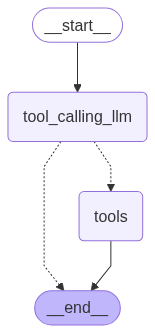

In [108]:
### Entire Chatbot With LangGraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode, tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}


# Build graph
builder = StateGraph(State)
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    # if the latest message (result) from assistant is tool call -> tool_condition routes to tools
    # if the latest message (result) from assistant is not a tool call -> tool_condition routes to END
    tools_condition
)
builder.add_edge('tools',END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [109]:
messages = graph.invoke(
    {
        "messages":HumanMessage(
            content='what is attention is all you need'
        )
    }
)

In [110]:
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

what is attention is all you need
================================== Ai Message ==================================
Tool Calls:
  wikipedia (mf1v40jnc)
 Call ID: mf1v40jnc
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi


In [111]:
messages = graph.invoke(
    {
        "messages":HumanMessage(
            content='provide me latest AI News'
        )
    }
)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

provide me latest AI News
================================== Ai Message ==================================
Tool Calls:
  tavily_search (rvrge5y7n)
 Call ID: rvrge5y7n
  Args:
    exclude_domains: None
    include_domains: None
    include_favicon: None
    include_images: None
    query: latest AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.techinasia.com/news/foxconn-cloud-unit-sees-over-50-q2-profit-surge-on-ai", "title": "Foxconn cloud unit sees over 50% Q2 profit surge on AI - Tech in Asia", "score": 0.48952848, "published_date": "Tue, 08 Jul 2025 08:16:00 GMT", "content": "Published Time: 2025-07-08\n\nFoxconn cloud unit sees over 50% Q2 profit surge on AI\n\

In [112]:
messages = graph.invoke(
    {
        "messages":HumanMessage(
            content='what is Machine learning?'
        )
    }
)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

what is Machine learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (kyjjqbb8v)
 Call ID: kyjjqbb8v
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi


In [113]:
messages = graph.invoke(
    {
        "messages":HumanMessage(
            content='what is 6+5?'
        )
    }
)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

what is 6+5?
================================== Ai Message ==================================

The result of 6 + 5 is 11.
